In [1]:
import cv2
import toml
import sys
import os
import time
from IPython.display import display, Image

sys.path.append(os.path.abspath("data_management"))
sys.path.append(os.path.abspath("onnx_models"))

import data_preprocessing as dprep
import data_postprocessing as dpostp
import onnx_inference as onnx_inf

%matplotlib inline

In [2]:
yolo_cfg = toml.load('yolov5n.toml')
imgsz = yolo_cfg['input_data']['imgsz']
conf_thres = yolo_cfg['predictor']['conf_thres']
iou_thres = yolo_cfg['predictor']['iou_thres']
classes = yolo_cfg['predictor']['classes']
if not classes:
    classes = None
onnx_model_path = yolo_cfg['onnx_model_path']
visualize = yolo_cfg['visualize']
out_img_path = yolo_cfg['out_img_path']
input_source = yolo_cfg['source']

In [3]:
stride, names, session, output_names = onnx_inf.load_model(onnx_model_path)

name 'cap' is not defined


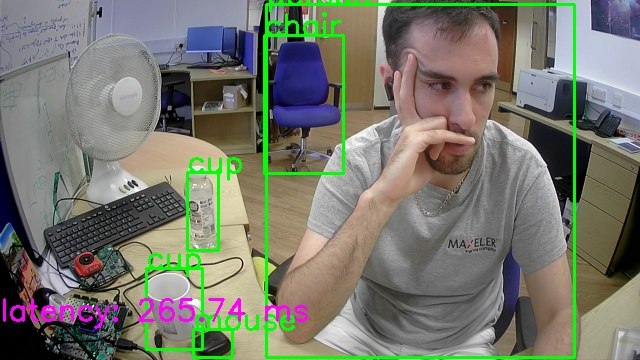

KeyboardInterrupt: 

In [4]:
try:
    cap.release()
    cap.destroyAllWindows()
except Exception as e:
    print(e)
    pass

if input_source == 'webcam':
    cap = cv2.VideoCapture(0) 
    display_handle=display(None, display_id=True)
else:
    cap = cv2.VideoCapture(input_source)

frame_count = 0
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check that frame is not empty
    if ret:
        orig_img = frame.copy()
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        img = dprep.img_preprocess(img, imgsz, stride)

        start_time = time.perf_counter() 
        predictions = onnx_inf.model_inf(img, session, output_names)

        predictions = dpostp.yolo_nms(predictions, conf_thres, iou_thres, classes)
        pred_time = (time.perf_counter() - start_time)*1000
        
        for pred in predictions:

            pred[:, :4] = dpostp.scale_boxes((imgsz, imgsz), pred[:, :4], orig_img.shape).round()

            for p in pred:
#                 print({"object":names[int(p[5])], "x":int(p[0]), "y":int(p[1]), "width":int(p[2])-int(p[0]), "height":int(p[3])-int(p[1])})

                if visualize:
                    cv2.rectangle(orig_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (0, 255, 0), 2)
                    cv2.putText(orig_img, names[int(p[5])], (int(p[0]), int(p[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # add the time for inference
        cv2.putText(orig_img, f"latency: {pred_time:.2f} ms", (0, imgsz), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
                
        if visualize:
            # cv2.imwrite(os.path.join(out_img_path, f'{frame_count}.png'), orig_img)
            _, disp_img = cv2.imencode('.jpeg', orig_img)
            display_handle.update(Image(data=disp_img.tobytes()))
            frame_count += 1

    else:
        break
        
try:
    cap.release()
    cap.destroyAllWindows()
    display_handle.update(None)
except Exception as e:
    print(e)
    pass